In [1]:
!pip install qiskit==0.45.1
!pip install qiskit-nature==0.7.1
!pip install pyscf
!pip install --upgrade pyscf
!pip install pylatexenc
!pip install qiskit-aer==0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.w

In [5]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
import numpy as np
# from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCC,UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
# from qiskit_algorithms.optimizers import SLSQP, NELDER_MEAD, SPSA, L_BFGS_B, P_BFGS, GradientDescent, ADAM, SPSA
from qiskit_algorithms.eigensolvers import VQD
from qiskit_algorithms.state_fidelities import ComputeUncompute, BaseStateFidelity
from qiskit.primitives import Estimator, Sampler, BaseEstimator, BackendEstimator
# from qiskit_aer.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit import Aer
#from qiskit.providers.aer import AerSimulator

from qiskit.utils import QuantumInstance
from qiskit import qpy


# Collect data to train

C:\Users\DELL\AppData\Roaming\Python\Python38\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


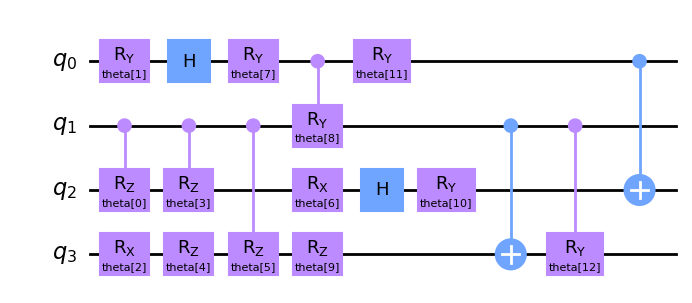

In [9]:
with open(f"./4qubits_10points_8circuits_6depth_20generations_VQE_H2_sto6g_fitness_2024-1-17_1000/best_circuit.qpy", "rb") as qpy_file_read:
    ansatz = qpy.load(qpy_file_read)[0]

# ansatz.draw("mpl").savefig("best_circuit_6depth.pdf", bbox_inches='tight')
ansatz.draw("mpl")

In [68]:
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD
import numpy as np
from qiskit_algorithms.utils import algorithm_globals
import numpy as np
from qiskit.algorithms.minimum_eigensolvers import VQE
# from qiskit_algorithms import VQE
from qiskit import qpy
import json

basis_set = 'sto6g'

distance = np.array(list(np.linspace(0.6, 0.8, 10)) + list(np.linspace(1.4, 1.6 , 10)) + list(np.linspace(2, 2.2, 10)))

VQE_with_bestcircuit_GAQAS = []

# seeds = np.arange(1,32)
seeds = [50]
data = {'distance': [], 'thetas': [], 'energy': []}



for i, dis in enumerate(distance):
  for j, seed in enumerate(seeds):
    interation = 100

    # file = open(f'result_H2-modify_{seed}.txt', 'w')
    theta = dis
    driver = PySCFDriver(
        # atom= f"H 0 {R*np.sin(theta/180*np.pi/2)} {R*np.cos(theta/180*np.pi/2)}; H 0 {-R*np.sin(theta/180*np.pi/2)} {-R*np.cos(theta/180*np.pi/2)}; H 0 {-R*np.sin(theta/180*np.pi/2)} {R*np.cos(theta/180*np.pi/2)}; H 0 {R*np.sin(theta/180*np.pi/2)} {-R*np.cos(theta/180*np.pi/2)} ",
        # atom = f"H 0 0 0; H 0 0 {dis}; H 0 0 {2*dis}; H 0 0 {3*dis}",
        atom = f"H 0 0 0; H 0 0 {dis}",
        basis= basis_set,
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    problem = driver.run()
    hamiltonian = problem.hamiltonian
    nuc = hamiltonian.nuclear_repulsion_energy
    hamiltonian = hamiltonian.second_q_op()

    mapper = JordanWignerMapper()

    qubit_op = mapper.map(hamiltonian)


    with open(f"best_circuit.qpy", "rb") as qpy_file_read:
        ansatz = qpy.load(qpy_file_read)[0]


    counts = []
    values = []
    steps = []

    def callback(eval_count, params, value, meta):
        counts.append(eval_count)
        values.append(value)
        # steps.append(step)


    # optimizer = NELDER_MEAD(maxiter=100)
    # optimizer = COBYLA(maxiter=1000)
    optimizer = SLSQP(maxiter=interation)
    # optimizer = GradientDescent(maxiter=100, learning_rate=0.01)
    # optimizer = SPSA(maxiter=5000, learning_rate=0.001, perturbation=0.001)
    # optimizer = ADAM(maxiter=2000, tol=1e-06, lr=seed*0.001, beta_1=0.9, beta_2=0.99)

    # optimizer = SLSQP(maxiter=40)

    # optimizer = COBYLA(maxiter=500)

    algorithm_globals.random_seed = seed
    estimator = Estimator()

    vqe = VQE(estimator = estimator, ansatz = ansatz, optimizer=optimizer, callback=callback)
    result1 = vqe.compute_minimum_eigenvalue(qubit_op)
    result = result1.eigenvalue.real + nuc
    VQE_with_bestcircuit_GAQAS.append(result)
    data['distance'].append(float(dis))
    data['thetas'].append(list(result1.optimal_point))
    data['energy'].append(float(result))
    print(data['energy'])
    # print(result1.optimal_parameters)
    # print(result1.optimal_point)
    # print(result1.optimal_circuit)
    # print(result)

# Save data
with open(f"data_many-sample_60_1.json", "w") as outfile:
  json.dump(data, outfile)

[-1.125596482727466]
[-1.125596482727466, -1.1325570642813174]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346, -1.1416279891783518]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346, -1.1416279891783518, -1.1441469661567694]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346, -1.1416279891783518, -1.1441469661567694, -1.1455502814921563]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346, -1.1416279891783518, -1.1441469661567694, -1.1455502814921563, -1.1459798946114144]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346, -1.1416279891783518, -1.1441469661567694, -1.1455502814921563, -1.1459798946114144, -1.145563626733325]
[-1.125596482727466, -1.1325570642813174, -1.1378277539238346, -1.1416279891783518, -1.1441469661567694, -1.1455502814921563, -1.1459798946114144, -1.145563626733325, -1.1444091358357948]
[-1.125596482727466, -1.1325570642813174, -1.137827753923

Text(0.5, 0, 'H-H distance [$\\AA$]')

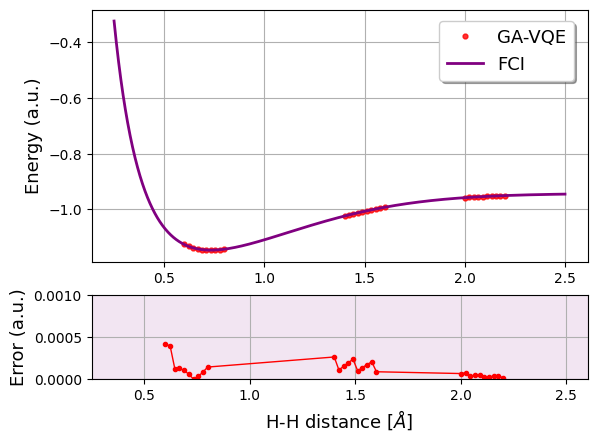

In [70]:
import matplotlib.pyplot as plt
# plt.plot(distance, data['energy'])
file = open('Hydrogen-molecules-sto6g-2000.txt', 'r').readlines()
# file1 = open('LiH-molecules-sto6g-2000.txt', 'r').readlines()

fontsize = 13
exact_FCI = []

fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

for i in range(len(file)):
  exact_FCI.append(eval(file[i].split(' ')[-2]))


distance2 = np.linspace(0.25, 2.5, 2000)

a0.grid()
a0.plot(distance, data['energy'], "r.", label = "GA-VQE", markersize = 7, alpha = 0.8)
a0.plot(distance2, exact_FCI, label = "FCI", color='purple', linewidth=2)
a0.legend(loc='upper right' ,bbox_to_anchor=(0.99, 0.99),  ncol=1, fancybox=True, shadow=True, fontsize=fontsize)
a0.set_ylabel('Energy (a.u.)', fontsize=fontsize)

exact_FCI_compared = []

for i in range(len(distance)):
  exact_FCI_compared.append(eval(file[int(np.round((distance[i]-0.25)/((2.5-0.25)/1999)) + 1)].split(" ")[-2]))


absolute_error = abs(np.array(exact_FCI_compared) - np.array(data["energy"]))

a1.grid()
a1.plot(distance, absolute_error, "o-", color = 'red', markersize=3, linewidth=1)
length = np.linspace(0.1,2.6,10)

a1.set_ylim((0, 0.001))
a1.set_xlim((0.25, 2.6))

a1.fill_between(length, np.zeros(len(length)), np.zeros(len(length)) + 1.6 * 1e-3 , color='purple', alpha=.1, label='Training interval')
a1.set_ylabel('Error (a.u.)', fontsize = fontsize)
a1.set_xlabel(r'H-H distance [$\AA$]', fontsize=fontsize)


Import data

In [1]:
import json

# Opening JSON file
f = open('./data_many-sample_60_1.json')
# Load data
data = json.load(f)
print(data)

{'distance': [0.6, 0.6222222222222222, 0.6444444444444445, 0.6666666666666666, 0.6888888888888889, 0.7111111111111111, 0.7333333333333334, 0.7555555555555555, 0.7777777777777778, 0.8, 1.4, 1.422222222222222, 1.4444444444444444, 1.4666666666666666, 1.488888888888889, 1.511111111111111, 1.5333333333333334, 1.5555555555555556, 1.577777777777778, 1.6, 2.0, 2.022222222222222, 2.0444444444444443, 2.066666666666667, 2.088888888888889, 2.111111111111111, 2.1333333333333333, 2.155555555555556, 2.177777777777778, 2.2], 'thetas': [[3.611860069224077, 3.31799934142087, 0.00010852342266755519, 5.949536809130025, -3.1567884331561515, 1.8462931831829381, -6.283018925841249, 1.5733851528975795, -3.0632283124935196, -2.79069794739149, 4.712199266922433, -3.1347346776368346, 0.0005661123598735531], [3.611860069224077, 3.32200695109866, -2.6561505983663366e-05, 5.949536809130025, -3.1507579537171804, 1.8462931831829383, -6.283233314760789, 1.5693927978251394, -3.0138617830666177, -2.7846663224363244, 4.7

In [73]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# load the dataset, split into input (X) and output (y) variables
# dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
X = data['distance']
y = data['thetas']

X = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
y = torch.tensor(y, dtype=torch.float32)


# define the model
model = nn.Sequential(
    nn.Linear(1, 9),
    nn.Sigmoid(),
    nn.Linear(9, 11),
    nn.ReLU(),
    nn.Linear(11, 10),
    nn.ReLU(),
    nn.Linear(10, 13)
)
print(model)

# train the model
# loss_fn   = nn.BCELoss()  # binary cross entropy
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 20000
batch_size = 10

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Finished epoch {epoch}, latest loss {loss}')

# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_pred = model(X)
    print(y_pred)
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

Streaming output truncated to the last 5000 lines.
Finished epoch 15091, latest loss 8.373268792638555e-05
Finished epoch 15092, latest loss 8.373051241505891e-05
Finished epoch 15093, latest loss 8.37261468404904e-05
Finished epoch 15094, latest loss 8.372658339794725e-05
Finished epoch 15095, latest loss 8.372962474822998e-05
Finished epoch 15096, latest loss 8.372947195312008e-05
Finished epoch 15097, latest loss 8.372755837626755e-05
Finished epoch 15098, latest loss 8.372567390324548e-05
Finished epoch 15099, latest loss 8.372718730242923e-05
Finished epoch 15100, latest loss 8.372862066607922e-05
Finished epoch 15101, latest loss 8.372786396648735e-05
Finished epoch 15102, latest loss 8.372534648515284e-05
Finished epoch 15103, latest loss 8.372533920919523e-05
Finished epoch 15104, latest loss 8.372659067390487e-05
Finished epoch 15105, latest loss 8.37279440020211e-05
Finished epoch 15106, latest loss 8.37251209304668e-05
Finished epoch 15107, latest loss 8.372308366233483e-05


Save model

In [81]:
torch.save(model, './model_H2_many_sample_60_1.pth')

Load model

In [2]:
import torch
model = torch.load("./model_H2_many_sample_60_1.pth")
model.eval()

Sequential(
  (0): Linear(in_features=1, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=11, bias=True)
  (3): ReLU()
  (4): Linear(in_features=11, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=13, bias=True)
)

Test model

In [74]:
from qiskit.primitives import Estimator

number = 100

a = np.linspace(0.25, 2.5, number)
a = torch.tensor(a, dtype=torch.float32).reshape(-1,1)

energy = []

with torch.no_grad():
    y_pred = model(a)

a = np.linspace(0.25, 2.5, number)

with open(f"./4qubits_10points_8circuits_6depth_20generations_VQE_H2_sto6g_fitness_2024-1-17_1000/best_circuit.qpy", "rb") as qpy_file_read:
      ansatz = qpy.load(qpy_file_read)[0]

for dis in range(len(y_pred.numpy())):
  driver = PySCFDriver(
        # atom= f"H 0 {R*np.sin(theta/180*np.pi/2)} {R*np.cos(theta/180*np.pi/2)}; H 0 {-R*np.sin(theta/180*np.pi/2)} {-R*np.cos(theta/180*np.pi/2)}; H 0 {-R*np.sin(theta/180*np.pi/2)} {R*np.cos(theta/180*np.pi/2)}; H 0 {R*np.sin(theta/180*np.pi/2)} {-R*np.cos(theta/180*np.pi/2)} ",
        # atom = f"H 0 0 0; H 0 0 {dis}; H 0 0 {2*dis}; H 0 0 {3*dis}",
        atom = f"H 0 0 0; H 0 0 {a[dis]}",
        basis= 'sto6g',
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

  problem = driver.run()
  hamiltonian = problem.hamiltonian
  nuc = hamiltonian.nuclear_repulsion_energy
  hamiltonian = hamiltonian.second_q_op()

  mapper = JordanWignerMapper()


  qubit_op = mapper.map(hamiltonian)

  estimator = Estimator().run(ansatz, qubit_op, y_pred.numpy()[dis])
  energy.append(estimator.result().values[0] + nuc)


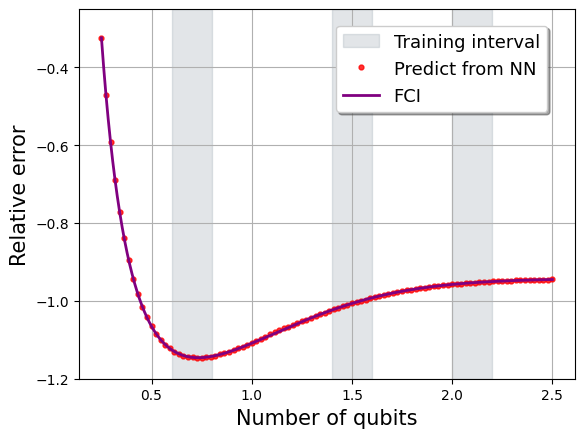

In [75]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

exact_FCI = []
fig, ax = plt.subplots()
# file1 = open('H4-chain-molecules-sto6g-2000.txt', 'r').readlines()
# file1 = open('H4-square-molecules-sto6g-2000.txt', 'r').readlines()
file1 = open('Hydrogen-molecules-sto6g-2000.txt', 'r').readlines()
# file1 = open('LiH-molecules-sto6g-2000.txt', 'r').readlines()

for i in range(len(file1)):
  exact_FCI.append(eval(file1[i].split(' ')[-2]))

# distance1 = np.linspace(0.5, 1.5, 100)
# distance1 = np.linspace(0.25, 5, 100)
distance2 = np.linspace(0.25, 2.5, 2000)
# distance1 = np.linspace(70, 110, 10)
plt.grid()
# X_input = np.linspace(0.25,2.5,10)
X_input_1 = np.linspace(0.6, 0.8, 10)
X_input_2 = np.linspace(1.4, 1.6 , 10)
X_input_3 = np.linspace(2, 2.2, 10)
plt.fill_between(X_input_1, np.zeros(len(X_input_1))-1.2,np.zeros(len(X_input_1))-0.25, color='slategrey', alpha=.2, label='Training interval')
plt.fill_between(X_input_2, np.zeros(len(X_input_2))-1.2,np.zeros(len(X_input_2))-0.25, color='slategrey', alpha=.2)
plt.fill_between(X_input_3, np.zeros(len(X_input_3))-1.2,np.zeros(len(X_input_3))-0.25, color='slategrey', alpha=.2)
plt.ylim((-1.2,-0.25))
# ax.fill_between(X_input, -0.2, 0., color='orange', alpha=.15, ec=None,
#                     transform=ax.get_xaxis_transform())
# distance2 = np.linspace(70, 110, 2000)
plt.plot(a, energy, "r.", label = "Predict from NN", markersize = 7, alpha = 0.8)
plt.plot(distance2, exact_FCI, label = "FCI", color='purple', linewidth=2)
plt.ylabel("Energy (a.u.)")
# plt.ylim(-1.91,-1.85)
plt.legend(loc='upper left' ,bbox_to_anchor=(0.5, 0.98),  ncol=1, fancybox=True, shadow=True, fontsize=13)
plt.ylabel('Relative error', fontsize=15)
plt.xlabel('Number of qubits', fontsize=15)
fig.savefig('NN-VQE.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Plot NN-VQE

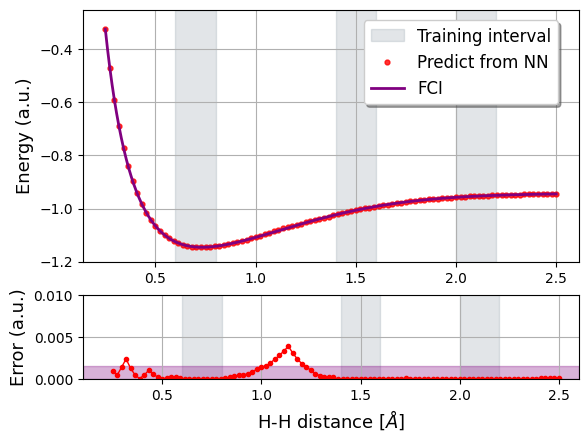

In [80]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


fontsize = 13
exact_FCI = []

fig, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
# file1 = open('H4-chain-molecules-sto6g-2000.txt', 'r').readlines()
# file1 = open('H4-square-molecules-sto6g-2000.txt', 'r').readlines()
file1 = open('Hydrogen-molecules-sto6g-2000.txt', 'r').readlines()
# file1 = open('LiH-molecules-sto6g-2000.txt', 'r').readlines()

for i in range(len(file1)):
  exact_FCI.append(eval(file1[i].split(' ')[-2]))

# distance1 = np.linspace(0.5, 1.5, 100)
# distance1 = np.linspace(0.25, 5, 100)
distance2 = np.linspace(0.25, 2.5, 2000)
# distance1 = np.linspace(70, 110, 10)
a0.grid()
# X_input = np.linspace(0.25,2.5,10)
X_input_1 = np.linspace(0.6, 0.8, 10)
X_input_2 = np.linspace(1.4, 1.6 , 10)
X_input_3 = np.linspace(2, 2.2, 10)
a0.fill_between(X_input_1, np.zeros(len(X_input_1))-1.2,np.zeros(len(X_input_1))-0.25, color='slategrey', alpha=.2, label='Training interval')
a0.fill_between(X_input_2, np.zeros(len(X_input_2))-1.2,np.zeros(len(X_input_2))-0.25, color='slategrey', alpha=.2)
a0.fill_between(X_input_3, np.zeros(len(X_input_3))-1.2,np.zeros(len(X_input_3))-0.25, color='slategrey', alpha=.2)
a0.set_ylim((-1.2,-0.25))
# ax.fill_between(X_input, -0.2, 0., color='orange', alpha=.15, ec=None,
#                     transform=ax.get_xaxis_transform())
# distance2 = np.linspace(70, 110, 2000)
a0.plot(a, energy, "r.", label = "Predict from NN", markersize = 7, alpha = 0.8)
a0.plot(distance2, exact_FCI, label = "FCI", color='purple', linewidth=2)
# plt.ylim(-1.91,-1.85)
a0.legend(loc='upper left' ,bbox_to_anchor=(0.55, 0.99),  ncol=1, fancybox=True, shadow=True, fontsize=12)
a0.set_ylabel('Energy (a.u.)', fontsize=fontsize)

exact_FCI_compared = []


file = open('Hydrogen-molecules-sto6g-2000.txt', 'r').readlines()

for i in range(100):
  dis = 0.25 + i*(2.5-0.25)/99
  exact_FCI_compared.append(eval(file[round((dis-0.25)/((2.5-0.25)/1999))].split(" ")[-2]))

a1.grid()

absolute_error = abs(np.array(exact_FCI_compared) - np.array(energy))

a1.plot(a, absolute_error, "o-", color = 'red', markersize=3, linewidth=1)

a1.set_ylim((0, 0.01))
a1.set_xlim((0.1, 2.6))
a1.fill_between(X_input_1, np.zeros(len(X_input_3)) + 0.02, color='slategrey', alpha=.2, label='Training interval')
a1.fill_between(X_input_2, np.zeros(len(X_input_3)) + 0.02, color='slategrey', alpha=.2)
a1.fill_between(X_input_3, np.zeros(len(X_input_3)),np.zeros(len(X_input_3)) + 0.02, color='slategrey', alpha=.2)

length = np.linspace(0.1,2.6,10)
a1.fill_between(length, np.zeros(len(length)), np.zeros(len(length)) + 1.6 * 1e-3 , color='purple', alpha=.3, label='Training interval')
a1.set_ylabel('Error (a.u.)', fontsize = fontsize)
a1.set_xlabel(r'H-H distance [$\AA$]', fontsize=fontsize)

fig.savefig('NN-VQE.pdf', format='pdf', dpi=600, bbox_inches='tight')